In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def deflection(l, d):
    E = 207e9
    P = 1e3
    return 64*P*(l**3)/(3.0*E*np.pi*(d**4))
def stress(l, d):
    P = 1e3
    return 32*P*l/(np.pi*(d**3))
def mass(l, d):
    g = 7800
    return (g*l*(d**2)/4)

In [3]:
def constrained_function(x, c, w):
    l = x[0]
    d = x[1]
    return w*mass(l,d) + (1-w)*deflection(l,d) + \
            c*(1e3*np.maximum(0, deflection(l,d) - 5e-3))**2 + \
            c*(1e-8*np.maximum(0, stress(l,d) - 3e8))**2 +\
            c*(1e1*np.maximum(0, l-1))**2 + (c)*(1e2*np.maximum(0,d-5e-2))**2 + \
            c*(1e1*np.minimum(0, l-0.2))**2 + c*(1e2*np.minimum(0, d-1e-2))**2

In [4]:
def constrained_function2(l, d, c, w):
    return w*mass(l,d) + (1-w)*deflection(l,d) + \
            c*(1e3*np.maximum(0, deflection(l,d) - 5e-3))**2 + \
            c*(1e-8*np.maximum(0, stress(l,d) - 3e8))**2 +\
            c*(1e1*np.maximum(0, l-1))**2 + (c)*(1e2*np.maximum(0,d-5e-2))**2 + \
            c*(1e1*np.minimum(0, l-0.2))**2 + c*(1e2*np.minimum(0, d-1e-2))**2

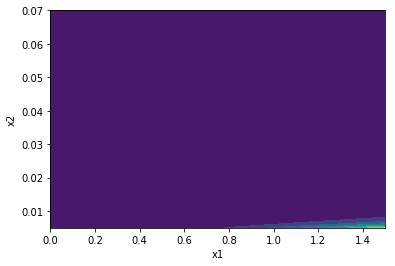

In [5]:
x1 = np.linspace(0, 1.5, 200)
x2 = np.linspace(0.5e-2, 7e-2, 200)
x1v, x2v = np.meshgrid(x1, x2)
z = constrained_function2(x1v, x2v, 0, 0.2)
plt.contourf(x1v,x2v,z)
plt.xlabel('x1')
plt.ylabel('x2')

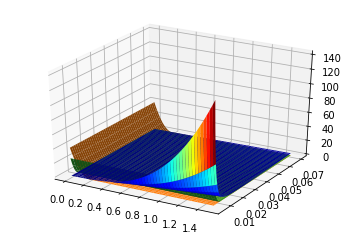

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 

plt.figure()
ax = plt.subplot(111, projection='3d')
ax.plot_surface(x1v,x2v,z, cmap=cm.jet)
ax.plot_surface(x1v, x2v, 1e3*np.minimum(0, x1v-0.2)**2)
ax.plot_surface(x1v, x2v, 1e6*np.minimum(0, x2v-1e-2)**2)

In [7]:
def create_new_base(direction, lam):
    new_base = np.zeros(direction.shape)
    D = direction.transpose()
    M = lam.transpose()
    Q = np.dot(D, M) #is really matrix multiplication for 2D arrays
    v = np.zeros(direction.shape)
    v[0] = Q[:,0] #as in classical method, first vector is unchanged, only normalized
    new_base[0] = v[0]/np.sqrt(np.dot(v[0].transpose(), v[0]))
    for j in range(1, len(direction)):
        scalar_dir = np.zeros(len(Q[0,:]))
        for k in range(0, j): #here happens the summation of vectors
            p = np.dot(Q[:,j].transpose(), new_base[k, :])
            p = np.multiply(p, new_base[k, :])
            scalar_dir = np.add(scalar_dir,p)
        v[j] = np.subtract(Q[:,j] ,scalar_dir)
        new_base[j] = v[j]/np.sqrt(np.dot(v[j].transpose(), v[j]))
    return new_base

def rosenbrock_method(function, x0, direction, s, alpha, beta, N, verbose, c, w):
    #alpha - expansion coefficient
    #beta - contraction coefficient
    lam = [0 for i in range(len(direction))] #success list for each direction
    p = [0 for i in range(len(direction))] #failure list for each direction
    i = 0
    x_base = x0
    x_list = []
    while i <= N:
        for j in range(len(direction)):
            if function(np.add(x_base,np.multiply(direction[j],s[j])),c, w) < function(x_base, c, w):
                #successful step
                x_base = np.add(x_base,np.multiply(direction[j],s[j]))
                x_list.append(x_base)
                lam[j] = np.add(lam[j],s[j])
                s[j] = np.multiply(alpha,s[j])
            elif function(np.add(x_base,np.multiply(direction[j],s[j])), c, w) >= function(x_base, c, w):
                #failed step
                s[j] = (-1)*s[j]*beta
                p[j] = np.add(p[j],1)
        for_all = 0
        for j in range(len(direction)):
            if p[j] !=0 and lam[j]!=0:
                for_all += 1
        if for_all == len(direction):
            l = np.zeros((2,2))
            l[0,0] = lam[0]
            l[1,0] = lam[1]
            l[1,1] = lam[1]
            direction = create_new_base(direction, l.transpose())  
            lam = [0 for i in range(len(direction))] #clear
            p = [0 for i in range(len(direction))] #clear
        i = i+1
    return x_base, x_list

In [9]:
def multicriterial_optimization(function, x_start, direction, s, alpha, beta, N, verbose, N2, error, w):
    min_list = []
    c = 0.5
    j = 0
    while j < N2:
        c = 2*c
        minimum, _ = rosenbrock_method(function, x_start, direction, s, alpha, beta, N, verbose, c, w)
        if np.abs(function(minimum,c, w)) < error and is_valid(minimum):
            min_list.append(minimum)
            return min_list
        j += 1
        min_list.append(minimum)
    return min_list

In [10]:
    w = 0.2
    s = np.array([0.1,0.1])
    direction = np.array([[1.0,0.0], [0.0,1.0]])
    x_start = np.array([0.0, 0.0])
    N2 = 15
    N = 10
    alpha = 3
    beta = 0.5
    x_start[0] = (0.8)*np.random.random() + 0.2 #len range [0.2, 1]
    x_start[1] = (4e-2)*np.random.random() + 1e-2 #diam range [0.01, 0.05]
    
    x_start = np.array([  0.25374301,  0.04232796])
    print(x_start)
    minimum = multicriterial_optimization(constrained_function, x_start, direction, s, alpha, beta, N, 0, N2, 1e-3, w)
    print(minimum)
    #print(constrained_function(minimum, 0, w))

[ 0.25374301  0.04232796]
[array([ 0.19454818,  0.02093968]), array([ 0.20100863,  0.01993526]), array([ 0.32243615,  0.0240315 ]), array([ 0.22422418,  0.0213445 ]), array([ 0.20706644,  0.02034336]), array([ 0.20371418,  0.01987713]), array([ 0.20281684,  0.02634145]), array([ 0.20398428,  0.02038058]), array([ 0.25017885,  0.02086013]), array([ 0.23045218,  0.02094208]), array([ 0.33276131,  0.02280097]), array([ 0.21397357,  0.02109644]), array([ 0.22167104,  0.01964317]), array([ 0.31330304,  0.02280588]), array([ 0.20814532,  0.02109571])]


In [11]:
print(constrained_function([0.75682298, 0.02063893],0,0.2))
s = np.array([0.1,0.1])
direction = np.array([[1.0,0.0], [0.0,1.0]])
N = 30
alpha = 3
beta = 0.5
c = 0.5
for i in range(0, 100):
    c = 2*c
    minimum, _ = rosenbrock_method(constrained_function, [0.25374301 , 0.04232796], direction, s, alpha, beta, N,0, c, 0.2)
    print(minimum, constrained_function(minimum, c, 0.2))

0.188427668779
[ 0.20682049  0.01914265] 0.0312965397383
[ 0.20597702  0.01911771] 0.0310913494675
[ 0.2137226   0.01936676] 0.033084053059
[ 0.21080214  0.01927203] 0.0323169111764
[ 0.28134073  0.02121911] 0.0522856238434
[ 0.20106144  0.02128019] 0.0365496630037
[ 0.20005568  0.01894006] 0.0296212946149
[ 0.20832316  0.01919702] 0.0316882976266
[ 0.24802596  0.02034832] 0.0423871333494
[ 0.26056403  0.02068325] 0.0460095808139
[ 0.20523819  0.01911775] 0.0309532065952
[ 0.21525921  0.01940908] 0.0334699795589
[ 0.247909    0.02034456] 0.0423518831854
[ 0.2568076   0.02058282] 0.0449073802859
[ 0.20422797  0.01907177] 0.0306606009833
[ 0.23014822  0.01984626] 0.0374154916689
[ 0.27484118  0.02105341] 0.0502839092448
[ 0.20013474  0.0189691 ] 0.0297102171384
[ 0.25029631  0.02040765] 0.0430267386243
[ 0.20080645  0.01896572] 0.0298120389555
[ 0.2440477   0.02023583] 0.0412494946702
[ 0.22451186  0.01968151] 0.0358965700598
[ 0.20369349  0.01905987] 0.0305396906938
[ 0.25951915  0.0206

In [14]:
w_list = []
for w in np.arange(0, 1.01, 0.01):
    #f1 is mass
    #f2 is deflection
    s = np.array([0.1,0.1])
    direction = np.array([[1.0,0.0], [0.0,1.0]])
    x_start = np.array([0.0, 0.0])
    N2 = 30
    N = 30
    alpha = 3
    beta = 0.5
    x_start[0] = (0.8)*np.random.random() + 0.2 #len
    x_start[1] = (4e-2)*np.random.random() + 1e-2 #diam
    minimum = multicriterial_optimization(constrained_function, x_start, direction, s, alpha, beta, N, 0, N2, 1e-3, w)
    #print("W : {}, length {}, diameter {}".format(w, minimum[-1][0], minimum[-1][1]))
    print("W : {}, mass {}, deflection {}".format(w, mass(minimum[-1][0], minimum[-1][1]), \
                                              deflection(minimum[-1][0], minimum[-1][1])))
    w_list.append(minimum[-1])

W : 0.0, mass 2.932686053046443, length 0.0011428805417129872
W : 0.01, mass 4.483608549107527, length 0.004999501593385831
W : 0.02, mass 0.1988452894559119, length 0.001081526343082871
W : 0.03, mass 0.18627803317073915, length 0.002078959177261861
W : 0.04, mass 0.6064715857807961, length 0.0049998725715689855
W : 0.05, mass 0.14407228692452898, length 0.002020779119578991
W : 0.06, mass 0.4302740933532627, length 0.004997923595751718
W : 0.07, mass 0.19465819229673836, length 0.002835499200443194
W : 0.08, mass 0.23598668260582648, length 0.003424678430241615
W : 0.09, mass 2.1559278787912013, length 0.004999967164641625
W : 0.1, mass 0.1459808605500473, length 0.0021067878590749108
W : 0.11, mass 5.405262307988695, length 0.004982898899803389
W : 0.12, mass 0.14462687623537984, length 0.0021064743134505625
W : 0.13, mass 3.160948719417114, length 0.0049998155827111436
W : 0.14, mass 0.1402571564170477, length 0.002032135548568997
W : 0.15, mass 1.4270748551221193, length 0.0049996

In [15]:
lengths = [element[0] for element in w_list]
diameters = [element[1] for element in w_list]
function_of_mass = [mass(l, d) for l, d in zip(lengths, diameters)]
function_of_deflection = [deflection(l,d) for l,d in zip(lengths, diameters)]
w = [w for w in np.arange(0, 1.01, 0.01)]

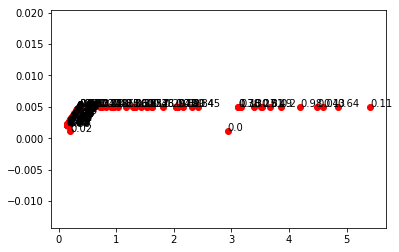

In [16]:
fig, ax = plt.subplots()
ax.scatter(function_of_mass, function_of_deflection, color='r')

for w, mass, deflection in zip(w, function_of_mass, function_of_deflection):
    ax.annotate(str(w), (mass, deflection))